In [5]:
import pyvista as pv
import numpy as np
# Create a sphere surface mesh
sphere_surface = pv.Sphere(radius=1.0, theta_resolution=5, phi_resolution=5)

# Convert to a tetrahedral mesh
tetra_mesh = sphere_surface.delaunay_3d()


/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/cellforge-Tgd_YqAD-py3.11/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/cellforge-Tgd_YqAD-py3.11/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


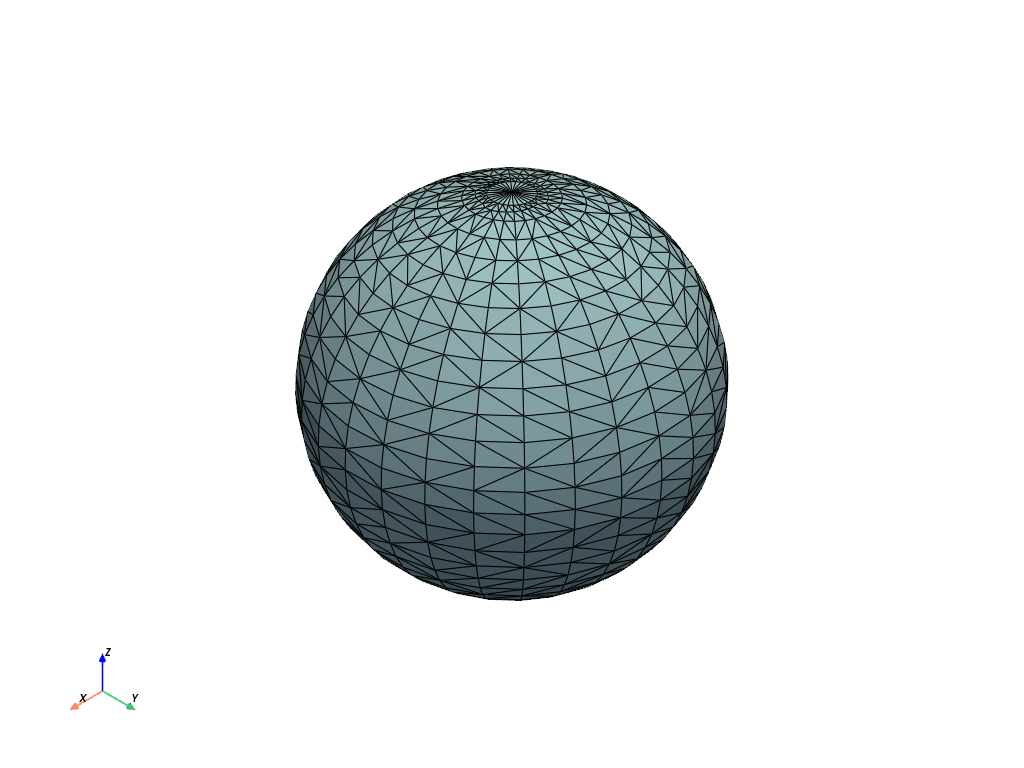

In [2]:
import pyvista as pv
import tetgen
import numpy as np

pv.set_plot_theme('document')

sphere = pv.Sphere(radius=1e-4)
tet = tetgen.TetGen(sphere)
tet.tetrahedralize()
grid = tet.grid
grid.plot(show_edges=True)

/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/cellforge-Tgd_YqAD-py3.11/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/cellforge-Tgd_YqAD-py3.11/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


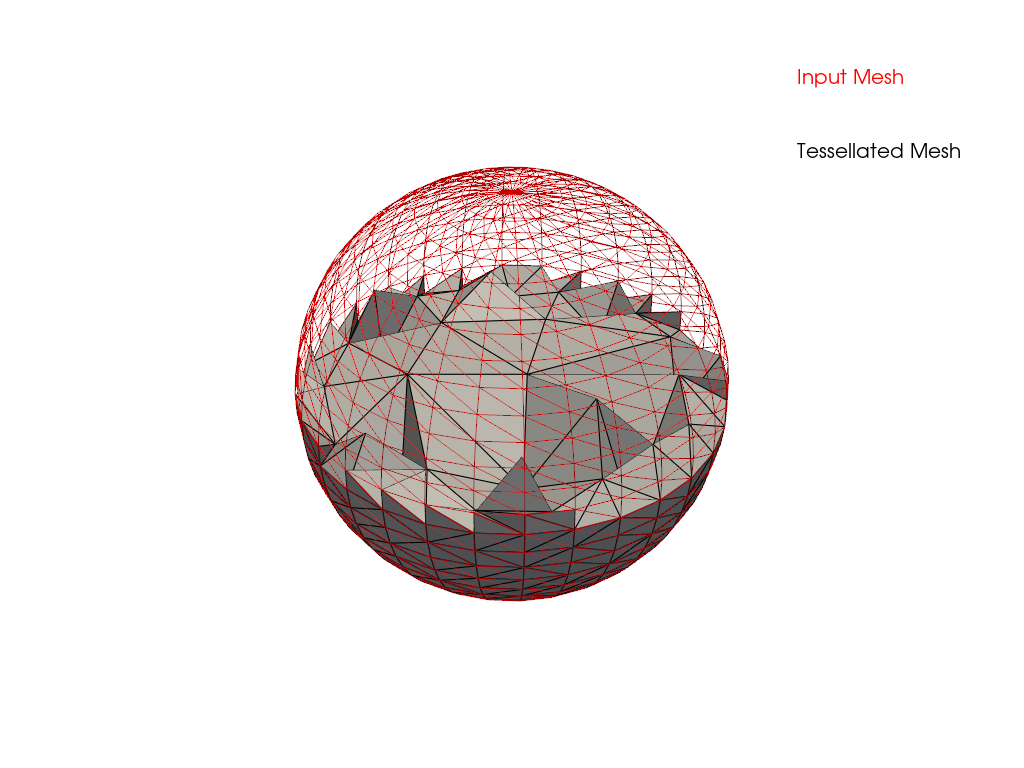

In [3]:
# get cell centroids
cells = grid.cells.reshape(-1, 5)[:, 1:]
cell_center = grid.points[cells].mean(1)

# extract cells below the 0 xy plane
mask = cell_center[:, 2] < 0
cell_ind = mask.nonzero()[0]
subgrid = grid.extract_cells(cell_ind)

# advanced plotting
plotter = pv.Plotter()
plotter.add_mesh(subgrid, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(sphere, 'r', 'wireframe')
plotter.add_legend([[' Input Mesh ', 'r'], [' Tessellated Mesh ', 'black']])
plotter.show()

In [4]:
cell_qual = subgrid.compute_cell_quality()['CellQuality']

/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/cellforge-Tgd_YqAD-py3.11/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/cellforge-Tgd_YqAD-py3.11/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


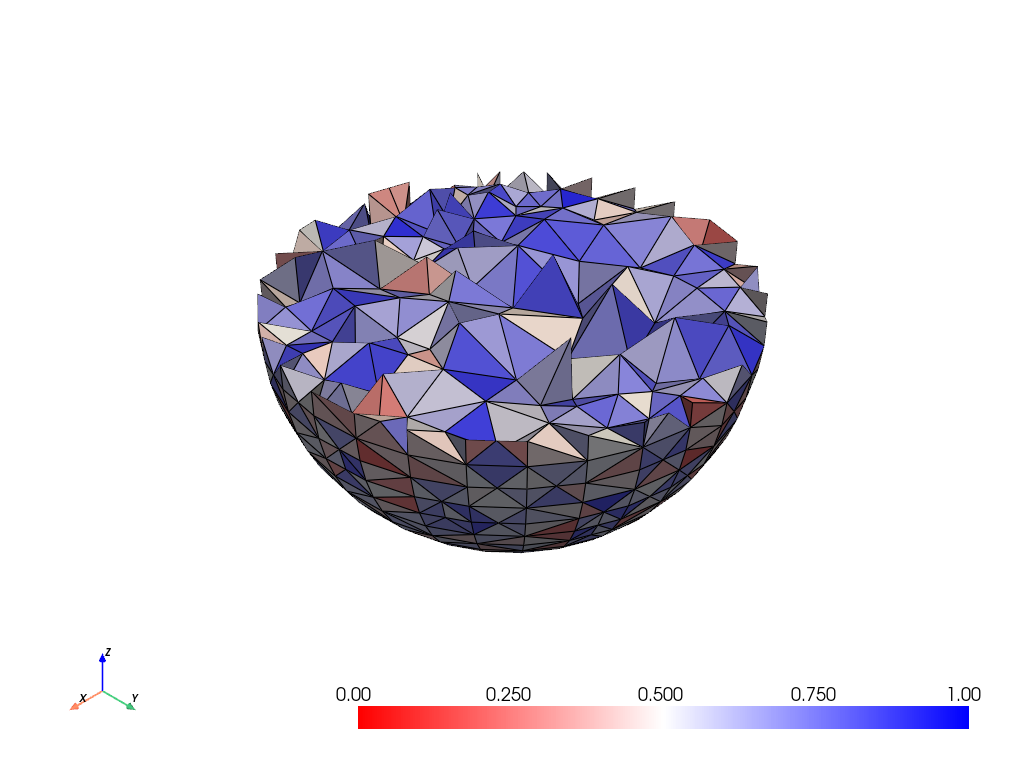

In [4]:
subgrid.plot(
    scalars=cell_qual,
    #  stitle='Quality',
    cmap='bwr',
    clim=[0, 1],
    flip_scalars=True,
    show_edges=True)

/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/phd-dWXyEp8j-py3.11/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


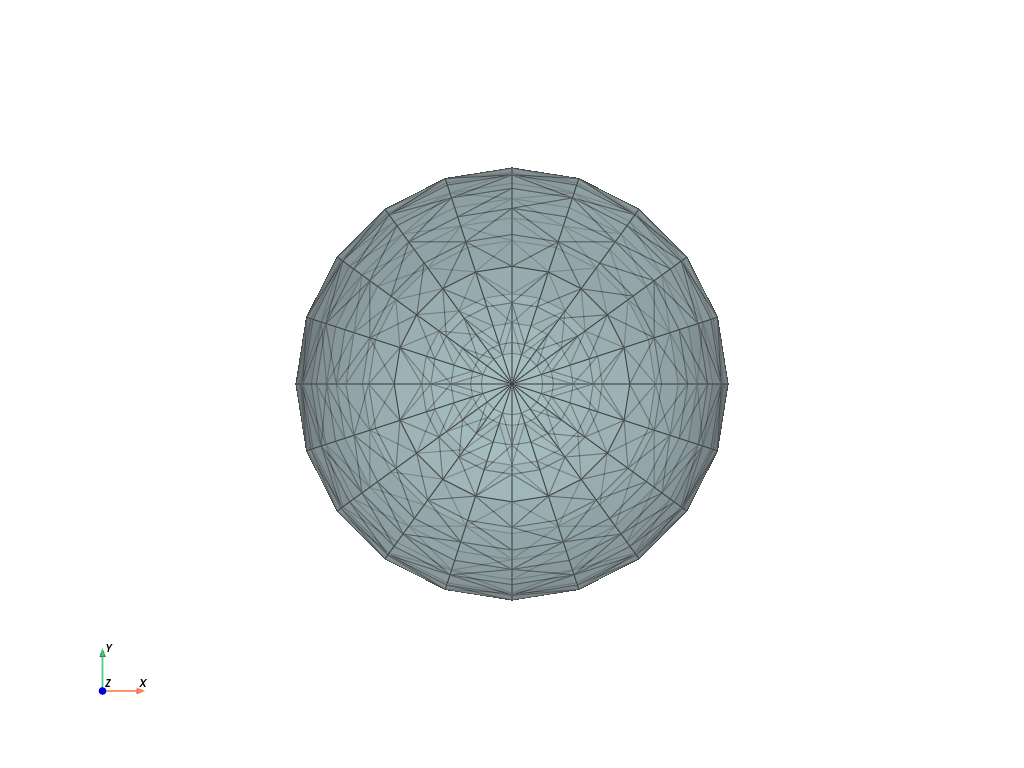

In [23]:
sphere_surface = pv.Sphere(radius=300.0,
                           theta_resolution=20,
                           phi_resolution=20)
tetra_mesh = sphere_surface.delaunay_3d(
)  # Use alpha parameter to control meshing

# Extract vertices and tetrahedral cells
vertices = tetra_mesh.points
tetra_indices = tetra_mesh.cells_dict[pv.CellType.TETRA].flatten()
# Create a PyVista plotter
plotter = pv.Plotter()

# Add the tetrahedral mesh to the plotter
plotter.add_mesh(
    tetra_mesh,  # The mesh to plot
    show_edges=True,  # Display mesh edges
    opacity=0.5,  # Set mesh opacity (0.0 to 1.0)
    color="lightblue",  # Set mesh color
)

# Add axes for reference
plotter.add_axes()

# Set camera position (optional)
plotter.view_xy()  # View from the top (X-Y plane)

# Display the plot
plotter.show()

In [6]:
import taichi as ti
import numpy as np

ti.init(arch=ti.cpu)  # You can also use 'ti.gpu' for GPU support if available

# Simulation parameters
n_particles = 100  # Number of particles (or small spheres)
dim = 3  # Simulation in 2D (you can extend this to 3D)
dt = 1e-3  # Time step
gravity = ti.Vector([0, -9.8])  # Gravitational force
elasticity = 0.8  # Bounciness coefficient
radius = 0.05  # Radius of the soft spheres
stiffness = 500  # Stiffness for the soft body interactions

# Particle properties
positions = ti.Vector.field(dim, dtype=ti.f32, shape=n_particles)
velocities = ti.Vector.field(dim, dtype=ti.f32, shape=n_particles)
forces = ti.Vector.field(dim, dtype=ti.f32, shape=n_particles)


# Initialize particle positions and velocities
@ti.kernel
def initialize():
    for i in range(n_particles):
        positions[i] = [ti.random() * 0.8 + 0.1,
                        ti.random() * 0.8 + 0.1]  # Random starting positions
        velocities[i] = [0.0, 0.0]  # Initially at rest


# Compute the forces between particles (soft sphere interactions)
@ti.kernel
def compute_forces():
    for i in range(n_particles):
        forces[i] = gravity  # Reset forces to just gravity

        for j in range(n_particles):
            if i != j:
                dir_vec = positions[i] - positions[j]
                dist = dir_vec.norm() + 1e-4  # Prevent division by zero

                if dist < 2 * radius:  # Check for overlap (soft body interaction)
                    overlap = 2 * radius - dist
                    force_direction = dir_vec.normalized()
                    forces[i] += stiffness * overlap * force_direction


# Update positions and velocities using simple Euler integration
@ti.kernel
def update():
    for i in range(n_particles):
        velocities[i] += dt * forces[i]
        positions[i] += dt * velocities[i]

        # Simple boundary conditions for box containment
        for d in ti.static(range(dim)):
            if positions[i][d] < radius:
                positions[i][d] = radius
                velocities[i][d] *= -elasticity
            elif positions[i][d] > 1 - radius:
                positions[i][d] = 1 - radius
                velocities[i][d] *= -elasticity


# Taichi GUI for visualization
gui = ti.GUI("Soft Spheres Simulation", res=(500, 500))

initialize()
while gui.running:
    compute_forces()
    update()

    # Draw the particles as circles
    gui.circles(positions.to_numpy(), radius=radius * 500, color=0x66ccff)
    gui.show()


[Taichi] Starting on arch=arm64


TaichiTypeError: 
While compiling `initialize_c82_0`, File "/var/folders/gb/2dm73f1s22n8755ydqgrblxw0000gn/T/ipykernel_17348/955084658.py", line 25, in initialize:
        positions[i] = [ti.random() * 0.8 + 0.1,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        ti.random() * 0.8 + 0.1]  # Random starting positions
                        ^^^^^^^^^^^^^^^^^^^^^^^^
cannot assign '[Tensor (2) f32]' to '[Tensor (3) f32]'

In [108]:
d = np.array([1000])
E = np.array([6e5])
v = np.array([0.4])
k_damp = 0.02

In [109]:
mesh_phys = MeshPhysicalProperties(density=d, v=v, E=E, k_damp=k_damp)

In [110]:
mesh_phys

MeshPhysicalProperties(density=array([1000]), v=array([0.4]), E=array([600000.]), k_damp=0.02, k_mu=array([214285.71428571]), k_lambda=array([857142.85714286]))